# COVID Prediction Model Pipeline

### By Dr Md Abdul Awal

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('seaborn-white')
%matplotlib inline

import xgboost as xgb
# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Helper functions
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


#from nhanes.utils import (GridSearchCVWrapper, 
                          #one_hot_encode, 
                        #  precision_recall_thershold, 
                         # plot_recall_vs_decision_boundary, 
                         # plot_multi_recall_vs_decision_boundary,
                         # plot_roc_curves,
                        #  plot_bootstrap_roc,
                        #  bootstrap_model, 
                         # roc_interp)



from utils import (       GridSearchCVWrapper, 
                          precision_recall_thershold, 
                          plot_recall_vs_decision_boundary, 
                          plot_multi_recall_vs_decision_boundary,
                          plot_roc_curves,
                          plot_bootstrap_roc,
                          bootstrap_model, 
                          roc_interp)


# remove after this is resolved:
# https://stackoverflow.com/questions/36373266/change-in-running-behavior-of-sklearn-code-between-laptop-and-desktop/37259431
import warnings
warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Import training and test sets

In [1]:
import numpy as np
import pandas as pd         

total_data='Select_K_Best.csv'

total_data = pd.read_csv(total_data)
total_data



covid19_test_results     age  temperature   pulse      rr  rhonchi  \
0                         0  58.000       36.950  81.000  18.000        0   
1                         0  35.000       36.750  77.000  16.000        0   
2                         0  12.000       36.950  74.000  17.000        0   
3                         0  46.000       36.750  66.000  18.000        0   
4                         0   0.000       36.250  84.637  12.000        0   
...                     ...     ...          ...     ...     ...      ...   
21573                     1  24.047       37.024  66.494  16.988        0   
21574                     1  14.204       37.003  72.796  16.068        0   
21575                     1  23.788       37.479  70.788  15.173        0   
21576                     1  25.470       36.997  66.316  16.633        0   
21577                     1  20.000       36.502  68.596  15.395        0   

       wheezes  cough  fever  loss_of_smell  loss_of_taste  
0            0      1      0              0              0  
1            0      1      0              0              0  
2            0      0      0              0              0  
3            0      1      0              0              0  
4            0      1      1              0              0  
...        ...    ...    ...            ...            ...  
21573        0      0      0              0              0  
21574        0      0      0              0              0  
21575        0      0      0              0              0  
21576        0      0      0              0              0  
21577        0      0      1              0              0  

[21578 rows x 11 columns]

In [3]:


X=total_data.drop(['covid19_test_results'], axis=1)
y=total_data.covid19_test_results

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)



In [4]:
#Saving
#X_train.to_csv(r'C:\Users\hp\OneDrive\COVID-19-clinical-classification-master\cleaned_data.csv', index = False)

### Split features and labels from training and test sets

In [5]:
# SVM
def hyperopt_train_test(params):
    clf = SVC(
        kernel='rbf',
        **params
    )
    return cross_val_score(clf, X_train, y_train).mean()

space4svm = {
    'C': hp.uniform('C', 0, 20),
    'gamma': hp.loguniform('gamma', -6, 6),
}



def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()

best = fmin(f, space4svm, algo=tpe.suggest, max_evals=30, trials=trials)

print ('best:')
print (best)


SVC_opt = SVC(C= best['C'], gamma=best['gamma'] ,kernel='rbf',probability=True )  ## SVC


100%|███████████████████████████████████████████████| 30/30 [43:16<00:00, 98.42s/trial, best loss: -0.8576462556328529]
best:
{'C': 11.703242389740343, 'gamma': 0.8813519937781908}


In [6]:
# RF
def hyperopt_train_test(params):
    clf = RandomForestClassifier(
     n_jobs=-1,
        **params
    )
    return cross_val_score(clf, X_train, y_train).mean()

#space4svm = {
    #'C': hp.uniform('x', 0, 1),
#    'gamma': hp.loguniform('gamma', -3, 3),
#}

space4rf = {
    'max_depth': hp.choice('max_depth', range(1,40)),
    'max_features': hp.choice('max_features', range(1,16)),
    'n_estimators': hp.choice('n_estimators', range(1,40)),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()

best = fmin(f, space4rf, algo=tpe.suggest, max_evals=30, trials=trials)

print ('best:')
print (best)

x=best['criterion']

if x==0:
  criterion1='gini'
else: 
   criterion1='entropy'

RF_opt=RandomForestClassifier(max_depth=best['max_depth'] ,max_features= best['max_features'], n_estimators= best['n_estimators'] , criterion=criterion1)  # RF
RF_opt_clf=RF_opt.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 30/30 [02:26<00:00, 12.88s/trial, best loss: -0.9364322816122721]
best:
{'criterion': 0, 'max_depth': 27, 'max_features': 2, 'n_estimators': 36}


In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
def objective(space):

    clf = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            learning_rate=space['learning_rate'],
                            colsample_bytree=space['colsample_bytree'],
                            gamma=space['gamma'],
                            n_jobs=space['n_jobs'],
                            max_depth = space['max_depth'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'])
    
    train, valid, y_train1, y_valid = train_test_split( X_train, y_train, test_size=0.33, random_state=42)
    
    XGB_clf=clf.fit(train, y_train1)
    
    


    #predictions = XGB_clf.predict(valid)
    #score = roc_auc_score(y_valid, predictions)
    # TODO: Add the importance for the selected features
    #print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    #loss = 1 - score
    #return {'loss': -score, 'status': STATUS_OK}

    
     
        
    #
     # Applying k-Fold Cross Validation
  
    accuracies = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = 10)
    CrossValMean = accuracies.mean()

    #print("CrossValMean:", CrossValMean)

    return{'loss':-CrossValMean, 'status': STATUS_OK }


##########

space= {
    
    'learning_rate':hp.uniform("learning_rate",0,.8),
    'min_child_weight': hp.choice('min_child_weight', range(1,30)),
    'max_depth': hp.choice('max_depth', range(1,30)),
    'subsample': hp.uniform ('subsample', 0.8, 1),     
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1.0),
    'n_estimators': hp.choice('n_estimators', range(1,400)), 
    'n_jobs': hp.choice('n_jobs', range(1,10)), 
    'gamma': hp.uniform('gamma', 0.0, 0.9)    
}



##########


#space4 ={
#        'max_depth': hp.quniform("x_max_depth", 5, 30, 1),
 #       'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
 #       'subsample': hp.uniform ('x_subsample', 0.8, 1)
#    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print( best)



XGBclf = xgb.XGBClassifier( n_estimators = best['n_estimators'],
                            learning_rate=best['learning_rate'],
                            colsample_bytree=best['colsample_bytree'],
                            gamma=best['gamma'],
                            n_jobs=best['n_jobs'],
                            max_depth = best['max_depth'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'])

XGB_opt=XGBclf



100%|███████████████████████████████████████████████| 30/30 [09:16<00:00, 13.54s/trial, best loss: -0.9688734942353804]
{'colsample_bytree': 0.5695500838257722, 'gamma': 0.0024328000747919423, 'learning_rate': 0.37567429220713283, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 326, 'n_jobs': 2, 'subsample': 0.9473677148129978}


In [8]:
# Optimized Model Making 

 


SVC_opt_clf=SVC_opt.fit(X_train, y_train)


RF_opt_clf=RF_opt.fit(X_train, y_train)





XGB_opt_clf=XGB_opt.fit(X_train, y_train)





### Performance Metrics 

In [9]:
## Probability
threshold = 0.5

RF_opt_clf_prob=RF_opt_clf.predict_proba(X_test)


XGB_opt_clf_prob=XGB_opt_clf.predict_proba(X_test)



SVC_opt_prob=SVC_opt.predict_proba(X_test)


## Predict

RF_opt_clf_predict=RF_opt_clf.predict(X_test)



XGB_opt_clf_predict=XGB_opt_clf.predict(X_test)



SVC_opt_predict=SVC_opt.predict(X_test)

## Saving

#LDA_opt_clf_predict =LDA_opt_clf_predict.astype(int)

np.save("RF_opt_clf_predict", RF_opt_clf_predict )

np.save("XGB_opt_clf_predict",XGB_opt_clf_predict)

np.save("SVC_opt_predict",  SVC_opt_predict)
np.save("test_label", y_test)


#np.savetxt("test_label.csv", X_test, delimiter=",")




In [10]:
# Create Ensemble with ADASSYN DATA
df_preds = pd.DataFrame({
        'RF': RF_opt_clf_prob[:,1],
        'XGB': XGB_opt_clf_prob[:,1],
        'SVM':SVC_opt_prob[:,1]
    
    })

#df_preds.loc[:,'Ensemble'] = df_preds.mean(axis=1)

In [11]:
for col in df_preds:
    print(col)
    print(metrics.classification_report(y_test, np.where(1 - df_preds.loc[:,col] > threshold, 0, 1)))

RF
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3602
           1       0.94      0.95      0.94      3519

    accuracy                           0.94      7121
   macro avg       0.94      0.94      0.94      7121
weighted avg       0.94      0.94      0.94      7121

XGB
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3602
           1       0.98      0.96      0.97      3519

    accuracy                           0.97      7121
   macro avg       0.97      0.97      0.97      7121
weighted avg       0.97      0.97      0.97      7121

SVM
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3602
           1       0.88      0.85      0.86      3519

    accuracy                           0.87      7121
   macro avg       0.87      0.87      0.87      7121
weighted avg       0.87      0.87      0.87      7121



In [12]:

#for col in df_preds_org:
  #  print(col)
 #   print(metrics.classification_report(y_test_original, np.where(1 - df_preds_org.loc[:,col] > threshold, 0, 1)))

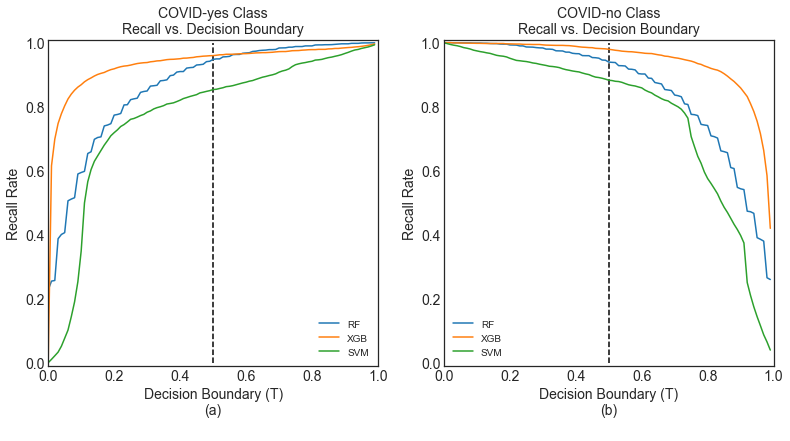

In [13]:
probas = dict(
         RF= RF_opt_clf_prob,
         XGB= XGB_opt_clf_prob,
         SVM=SVC_opt_prob
)

filename='Recall_score_all_with_ADASYN.png'
plot_multi_recall_vs_decision_boundary(probas, y_test,filename)

# ROC Curve

RF
  AUC: 0.986
XGB
  AUC: 0.991
SVM
  AUC: 0.913


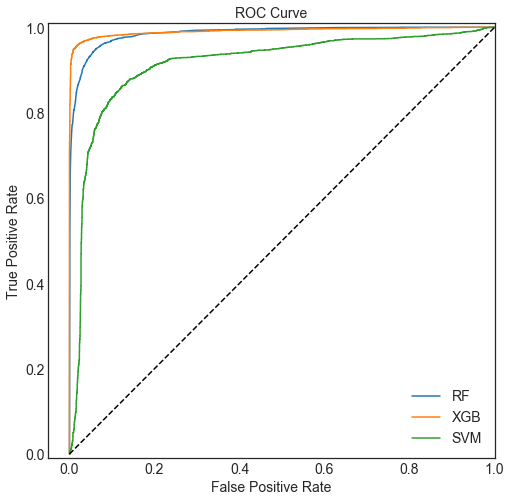

In [14]:
filename='ROC_curve_covid.png'
plot_roc_curves(df_preds, y_test,filename)



### Bootstrap ROC Curve for GradientBoostingClassifier

### Bootstrap mean and empirical confidence intervals

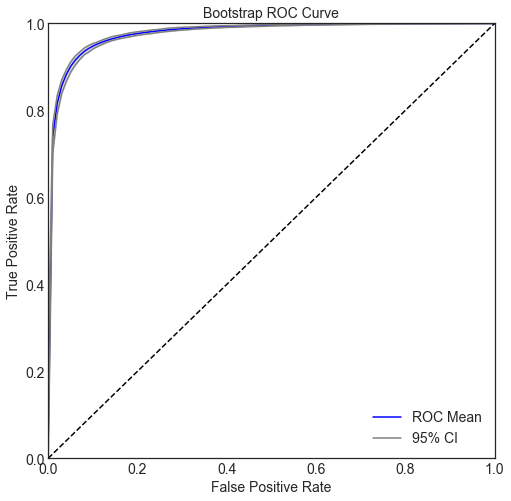

In [20]:
# Warning: bootstraping may take a while  with ADASYN
X_train1=X_train.reset_index(drop=True)
y_train1=y_train.reset_index(drop=True)
X_test1=X_test.reset_index(drop=True)
y_test1=y_test.reset_index(drop=True)




results = bootstrap_model(
    RF_opt_clf,
    X_train1, 
    y_train1, 
    X_test1, 
    y_test1,
    100,   # change the number of bootstraps here
    0.5
)

    
total_auc = []
for r in results['fpr_tpr']:
    total_auc.append(metrics.auc(r[0], r[1]))
total_auc
df_interp = pd.DataFrame(roc_interp(results['fpr_tpr'])).T
m = df_interp.mean(axis=1).values.tolist()
ci = df_interp.quantile([.025, .975], axis=1).values.tolist()

filename_bootstrap='Bootstrap_ROC_covid_RF.png'
plot_bootstrap_roc(m, ci,filename_bootstrap)



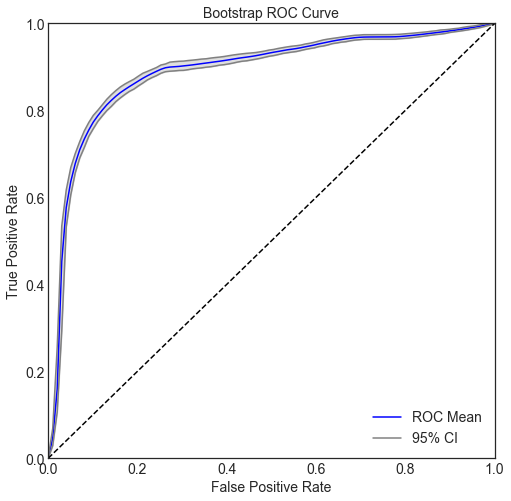

In [24]:
## with test data 


X_train1=X_train.reset_index(drop=True)
y_train1=y_train.reset_index(drop=True)
X_test1=X_test.reset_index(drop=True)
y_test1=y_test.reset_index(drop=True)



results_org = bootstrap_model(
    SVC_opt_clf,
    X_train1, 
    y_train1, 
    X_test1, 
    y_test1,
    100,   # change the number of bootstraps here
    0.5
)

    
total_auc_org = []
for r in results_org['fpr_tpr']:
    total_auc_org.append(metrics.auc(r[0], r[1]))
total_auc_org
df_interp_org = pd.DataFrame(roc_interp(results_org['fpr_tpr'])).T
m_org = df_interp_org.mean(axis=1).values.tolist()
ci_org = df_interp_org.quantile([.025, .975], axis=1).values.tolist()

filename_bootstrap_org='Bootstrap_ROC_covid_SVM.png'
plot_bootstrap_roc(m_org, ci_org,filename_bootstrap_org)

### 10 fold CV

In [25]:
# for 10 fold cross validation with ADASYN

#df_train = pd.read_csv('C:/Users/Awal/Desktop/NHANES_Clinical variales/train_data_ADASYN_clinical.csv')
#df_test = pd.read_csv('C:/Users/Awal/Desktop/NHANES_Clinical variales/test_data_ADASYN_clinical.csv')



#Data1 = pd.concat([df_train, df_test], axis=0)

#Data = Data1.drop(['status'], axis=1)
#label= Data1.status

Data=X
label=y
from sklearn.model_selection import cross_val_score


scoresSVC_opt = cross_val_score(SVC_opt, Data, label, cv=10)
scoresRF_opt = cross_val_score(RF_opt, Data, label, cv=10)
scoresXGB_opt = cross_val_score(XGB_opt, Data, label, cv=10)


np.save("scoresSVC_opt", scoresSVC_opt)
np.save("scoresRF_opt", scoresRF_opt )

np.save("scoresXGB_opt", scoresXGB_opt)







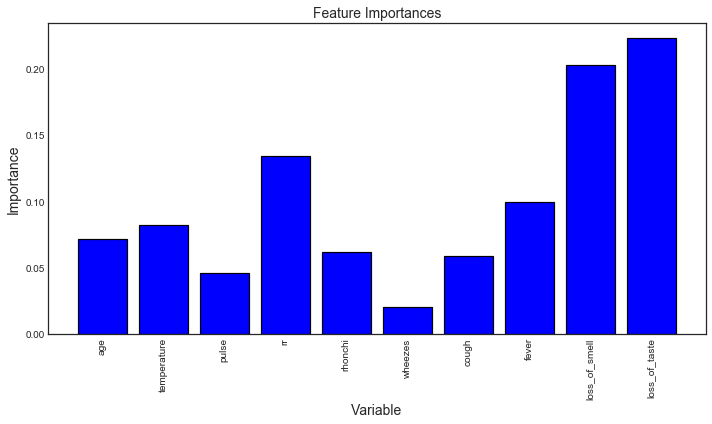

In [26]:
#Using XGB

# List of features for later use
feature_list = list(X_train.columns)


importances = list(XGB_opt_clf.feature_importances_)
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.figure(figsize=(10,6))
plt.bar(x_values, importances, orientation = 'vertical', color = 'b', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance', fontsize=14); plt.xlabel('Variable', fontsize=14); plt.title('Feature Importances', fontsize=14);

filename='Feature_ImportancesUsingXGB.png'

#plt.tick_params(axis='both', which='major', labelsize=14)


plt.tight_layout()
plt.savefig(filename,dpi=700)

plt.show()

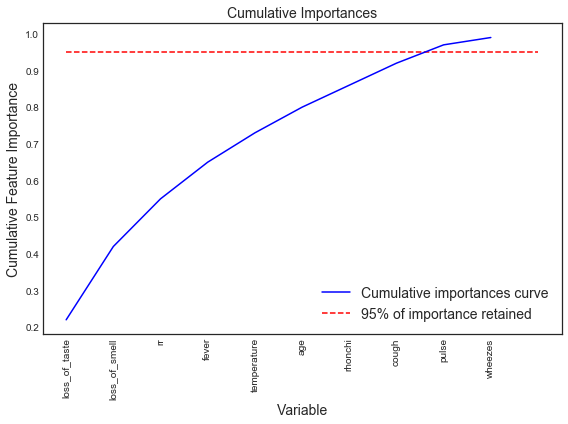

In [28]:
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

plt.figure(figsize=(8,6))
# Make a line graph
plt.plot(x_values, cumulative_importances,'b-',label='Cumulative importances curve')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed',label='95% of importance retained')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable', fontsize=14); plt.ylabel('Cumulative Feature Importance', fontsize=14); plt.title('Cumulative Importances', fontsize=14);

plt.legend()

#plt.gca().legend(('','95% of importance retained')
plt.legend(loc='lower right', fontsize=14)

filename='CumulativeFeatureImportanceUsingXGB.png'
plt.tight_layout()
plt.savefig(filename,dpi=350)

plt.show()

In [29]:



import pickle
# save the model to disk.
filename = 'final_Optimized_model_svc.sav'
pickle. dump(SVC_opt_clf, open(filename, 'wb'))


filename = 'final_Optimized_model_RF.sav'
pickle. dump(RF_opt_clf, open(filename, 'wb'))


filename = 'final_Optimized_model_XGB.sav'
pickle. dump(XGB_opt_clf, open(filename, 'wb'))
